In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class AbstractParamODETarget:
    def __init__(self, dt=1e-3, t_step=0.1, dim=2, param_dim=2):
        """
        Initializes an instance of the class.

        Parameters:
        - dt (float): The time step size for the inner loop to compute the value at each outer time step t_step.
        - t_step (float): The outer time step.
        - dim (int): The dimension of the system state.
        - param_dim (int): The dimension of the parameters.

        Returns:
        None
        """
        self.dt = dt
        self.t_step = t_step
        self.n_step = int(t_step / dt)
        self.dim = dim
        self.param_dim = param_dim

    def rhs(self, x, param):
        """
        Right-hand side of the ODE to be implemented by subclasses.

        :param x: state variable
        :param param: parameters for the ODE
        :return: the time derivative of x
        """
        raise NotImplementedError("Subclasses should implement this method.")

    def euler(self, x, param):
        """
        ODE Solver using Euler's method.

        :param x: state variable
        :param param: parameters for the ODE
        :return: ODE Solution at t_step after iterating the Euler method n_step times
        """
        for _ in range(self.n_step):
            x = x + self.dt * self.rhs(x, param)
        return x

    def generate_init_data(self, n_traj, traj_len, x_min, x_max, param_min, param_max, seed_x=11, seed_param=22):
        """
        Generate initial data for the ODE system. 
        In this case, the initial data is generated randomly. 
        The corresponding parameters are the same on each trajectory. But for different trajectories, the parameters are different.

        Parameters:
        - n_traj (int): Number of trajectories to generate.
        - traj_len (int): Length of each trajectory.
        - x_min, x_max (float): Range for the initial state.
        - param_min, param_max (float): Range for the parameters.
        - seed_x (int): Seed for random number generator for generating initial states.
        - seed_param (int): Seed for random number generator for generating parameters.

        Returns:
        - data_x (ndarray): Array of shape (n_traj * traj_len, self.dim) containing the generated initial states.
        - param (ndarray): Array of shape (n_traj * traj_len, self.param_dim) containing the generated parameters.
        """
        np.random.seed(seed_x)
        x0 = np.random.uniform(low=x_min, high=x_max, size=(n_traj, self.dim))

        np.random.seed(seed_param)
        param = np.random.uniform(low=param_min, high=param_max, size=(n_traj, self.param_dim))

        data_x = [x0]
        for t in range(traj_len - 1):
            data_x.append(self.euler(data_x[t], param))

        # Reshape and transpose data_x for the correct format
        data_x = np.array(data_x).reshape(n_traj * traj_len, self.dim)

        # Repeat parameters for each trajectory length
        repeats_constant = traj_len * np.ones(shape=(n_traj,), dtype="int32")
        param = np.repeat(param, repeats=repeats_constant, axis=0)

        return np.asarray(data_x), np.asarray(param)

    def generate_next_data(self, data_x, param):
        """
        Generate the next state using the Euler solver.

        Parameters:
        - data_x (ndarray): The current state of the system.
        - param (ndarray): Parameters of the ODE.

        Returns:
        - data_y (ndarray): The next state of the system after applying Euler's method.
        """
        data_y = self.euler(data_x, param)
        return data_y


In [4]:
class VanderPolMathieuTarget(AbstractParamODETarget):
    def __init__(self, mu=1, dt=1e-3, t_step=1e-2, dim=2, param_dim=1, k1=2, k2=2, k3=2, k4=1, w0=1):
        """
        Initializes the VanderPolMathieuTarget system.

        Parameters:
        - mu (float): Van der Pol oscillator parameter.
        - dt (float): Time step size for the inner loop.
        - t_step (float): Time step for the outer loop.
        - dim (int): Dimension of the state.
        - param_dim (int): Dimension of the parameters.
        - k1, k2, k3, k4, w0 (float): System parameters for the Van der Pol-Mathieu equation.

        """
        super().__init__(dt, t_step, dim, param_dim)
        self.x_min = -1
        self.x_max = 1
        self.u_min = -1
        self.u_max = 1
        self.mu = mu
        self.k1 = k1
        self.k2 = k2
        self.k3 = self.mu
        self.k4 = k4
        self.w0 = w0

    def rhs(self, data_x, param):
        """
        Compute the right-hand side of the Van der Pol-Mathieu system.

        Parameters:
        - data_x (ndarray): The current state of the system (shape: [n_traj, dim]).
        - param (ndarray): The system parameters (shape: [n_traj, param_dim]).

        Returns:
        - ndarray: The time derivative of the system state (shape: [n_traj, dim]).
        """
        x1 = np.reshape(data_x[:, 0], newshape=(data_x.shape[0], 1))
        x2 = np.reshape(data_x[:, 1], newshape=(data_x.shape[0], 1))
        param = np.reshape(param, newshape=(data_x.shape[0], 1))  # Ensure param is correctly reshaped

        f1 = x2
        f2 = (
            (self.k1 - self.k2 * x1**2) * x2
            - (self.w0**2 + 2 * self.k3 * param**2 - self.k3) * x1
            + self.k4 * param
        )
        return np.concatenate([f1, f2], axis=-1)

    def generate_init_data(self, n_traj, traj_len, seed_x=11, seed_param=22):
        """
        Generate initial data for the Van der Pol-Mathieu system.
        In this case, the initial data is generated randomly. 
        The corresponding parameter inputs (controls) are randomly generates at each time steps on each trajectory. For different trajectories, the parameters are different.

        Parameters:
        - n_traj (int): Number of trajectories.
        - traj_len (int): Length of each trajectory.
        - seed_x (int): Random seed for generating initial state.
        - seed_param (int): Random seed for generating parameters.

        Returns:
        - data_x (ndarray): Generated state data of shape (n_traj * traj_len, dim).
        - param (ndarray): Generated parameters of shape (n_traj * traj_len, param_dim).
        """
        data_x = []

        # Generate random initial states
        np.random.seed(seed_x)
        x0 = np.random.uniform(low=self.x_min, high=self.x_max, size=(n_traj, self.dim))

        # Generate random parameters
        np.random.seed(seed_param)
        param = np.random.uniform(low=self.u_min, high=self.u_max, size=(traj_len, n_traj, self.param_dim))

        # Euler integration for the trajectories
        data_x.append(x0)
        for t in range(traj_len - 1):
            x_next = self.euler(data_x[-1], param[t])
            data_x.append(x_next)

        # Reshape data_x and param for correct output format
        data_x = np.array(data_x).reshape(-1, self.dim)
        param = np.array(param).reshape(-1, self.param_dim)

        return data_x, param

    def generate_data(self, n_traj, traj_len, seed_x=11, seed_param=22):
        """
        Generate initial data for the Van der Pol-Mathieu system.
        In this case, the initial data is generated randomly. 
        The corresponding parameter inputs (controls) are randomly generates at each time steps on each trajectory. For different trajectories, the parameters are different.

        Parameters:
        - n_traj (int): Number of trajectories.
        - traj_len (int): Length of each trajectory.
        - seed_x (int): Random seed for generating initial state.
        - seed_param (int): Random seed for generating parameters.

        Returns:
        - data_x (ndarray): Generated state data of shape (n_traj * traj_len, dim).
        - param (ndarray): Generated parameters of shape (n_traj * traj_len, param_dim).
        """
        data_x = []

        # Generate random initial states
        np.random.seed(seed_x)
        x0 = np.random.uniform(low=self.x_min, high=self.x_max, size=(n_traj, self.dim))

        # Generate random parameters
        np.random.seed(seed_param)
        param = np.random.uniform(low=self.u_min, high=self.u_max, size=(traj_len-1, n_traj, self.param_dim))

        # Euler integration for the trajectories
        data_x.append(x0)
        for t in range(traj_len - 1):
            x_next = self.euler(data_x[-1], param[t])
            data_x.append(x_next)

        # Reshape data_x and param for correct output format
        data_x = np.array(data_x).transpose(1, 0, 2) # (n_traj, traj_len, dim)
        param = np.array(param).transpose(1, 0, 2)

        return data_x, param


In [5]:
target_dim = 2
param_dim = 1

# fixed parameters in VanderPolMathieuTarget
k1=2
k2=2
k3=2
k4=1
w0=1

In [6]:
# parameter for strong non-linearity
# As mu increases, the system becomes more non-linear
mu = 1

In [7]:
n_traj = 1000
traj_len = 50

In [8]:
vdp_mathieu = VanderPolMathieuTarget(
        mu=mu, dim=target_dim, param_dim=param_dim, k1=k1, k2=k2, k4=k4, w0=w0
    )
data_x, data_u = vdp_mathieu.generate_init_data(
    n_traj=n_traj, traj_len=traj_len, seed_x=625, seed_param=521
)
data_y = vdp_mathieu.generate_next_data(data_x, data_u)

In [9]:
# Reshape data to shape: (n_traj, traj_len, dim)
data_x = data_x.reshape(traj_len, n_traj, target_dim).transpose(1, 0, 2)
data_u = data_u.reshape(traj_len, n_traj, param_dim).transpose(1, 0, 2)
data_y = data_y.reshape(traj_len, n_traj, target_dim).transpose(1, 0, 2)

In [10]:
data_x.shape

(1000, 50, 2)

Text(0, 0.5, '$x_2$')

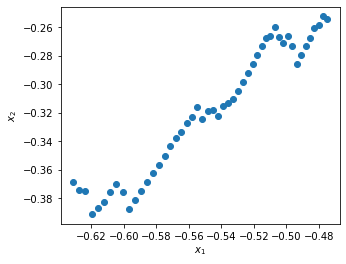

In [11]:
# Plot one trajectory
plt.figure(figsize=(5, 4))
plt.plot(data_x[0, :, 0], data_x[0, :, 1], "o")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

# Build Model

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

In [13]:
from tqdm import tqdm

In [14]:
torch.set_default_dtype(torch.float64)

## Dictionary

In [15]:
class AbstractDictionary:
    def __init__(self, n_psi_train, add_constant=True):
        self.n_psi_train = n_psi_train
        self.add_constant = add_constant

    def generate_B(self, inputs):
        target_dim = inputs.shape[-1]  # Get the last dimension of the input tensor

        if self.add_constant:
            self.n_psi = self.n_psi_train + target_dim + 1
            # Initialize B matrix with zeros
            self.B = torch.zeros((self.n_psi, target_dim), dtype=inputs.dtype, device=inputs.device)
            # Setting the sub-diagonal elements to 1
            for i in range(target_dim):
                self.B[i + 1, i] = 1.0
        else:
            self.basis_func_number = self.n_psi_train + target_dim
            # Initialize B matrix with zeros
            self.B = torch.zeros((self.basis_func_number, target_dim), dtype=inputs.dtype, device=inputs.device)
            # Setting the diagonal elements to 1
            for i in range(target_dim):
                self.B[i, i] = 1.0

        return self.B
    
class DicNN(nn.Module):
    """Trainable dictionaries."""

    def __init__(self, inputs_dim = 1, layer_sizes=[64, 64], n_psi_train=22, activation_func='tanh'):
        super(DicNN, self).__init__()
        self.inputs_dim = inputs_dim
        self.layer_sizes = layer_sizes
        self.n_psi_train = n_psi_train
        self.activation_func = activation_func
        
        # Creating the input layer
        self.input_layer = nn.Linear(self.inputs_dim, layer_sizes[0], bias=False)
        
        # Creating hidden layers
        self.hidden_layers = nn.ModuleList()
        for in_features, out_features in zip(layer_sizes[:-1], layer_sizes[1:]):
            self.hidden_layers.append(nn.Linear(in_features, out_features))
        
        # Creating the output layer
        self.output_layer = nn.Linear(layer_sizes[-1], n_psi_train)

    def forward(self, inputs):
        # Check layer dimension
        if inputs.shape[-1] != self.inputs_dim:
            print(f"Error: Expected input dimension {self.inputs_dim}, but got {inputs.shape[-1]}")
            return None  # Optionally, you could raise an exception here

        # Apply the input layer
        psi_x_train = self.input_layer(inputs)
        
        # Apply hidden layers with residual connections
        for layer in self.hidden_layers:
            if self.activation_func == 'tanh':
                psi_x_train = psi_x_train + F.tanh(layer(psi_x_train))
            elif self.activation_func == 'relu':
                psi_x_train = psi_x_train + F.relu(layer(psi_x_train))
            else:
                raise ValueError("Unsupported activation function")

        # Apply the output layer
        outputs = self.output_layer(psi_x_train)
        return outputs

class PsiNN(nn.Module, AbstractDictionary):
    def __init__(self, inputs_dim=1, dic_trainable=DicNN, layer_sizes=[64, 64], n_psi_train=22, activation_func='tanh', add_constant=True):
        super(PsiNN, self).__init__()
        self.n_psi_train = n_psi_train
        self.add_constant = add_constant
        # Create an instance of the dic_trainable with given parameters
        self.dicNN = dic_trainable(inputs_dim, layer_sizes, n_psi_train, activation_func) if n_psi_train != 0 else None

    def forward(self, inputs):
        outputs = []

        # Add a constant column of ones
        if self.add_constant:
            constant = torch.ones_like(inputs)[...,[0]]
            outputs.append(constant)

        # Add the original inputs
        outputs.append(inputs)

        # Add the output from dicNN if applicable
        if self.n_psi_train != 0:
            psi_x_train = self.dicNN(inputs)
            outputs.append(psi_x_train)

        # Concatenate along the feature dimension
        outputs = torch.cat(outputs, dim=-1) if len(outputs) > 1 else outputs[0]

        return outputs


## Model K

In [82]:
class Model_K_u_Layer_One(nn.Module):
    """Trainable K(u), the first row is (1,0,0,...)"""

    def __init__(self, inputs_dim=2, layer_sizes=[64, 64], n_psi=3, activation="tanh"):
        super(Model_K_u_Layer_One, self).__init__()
        self.inputs_dim = inputs_dim
        self.layer_sizes = layer_sizes
        self.n_psi = n_psi

        # Creating the input layer
        self.input_layer = nn.Linear(self.inputs_dim, layer_sizes[0], bias=False)

        # Create hidden layers
        self.hidden_layers = nn.ModuleList()
        for in_features, out_features in zip(layer_sizes[:-1], layer_sizes[1:]):
            self.hidden_layers.append(nn.Linear(in_features, out_features))

        # Output layer
        self.output_layer = nn.Linear(in_features=layer_sizes[-1],
                                      out_features=n_psi * (n_psi - 1),
                                      bias=True)

        # Choose activation function
        self.activation_func = activation

    def forward(self, inputs):
        # inputs shape is (n_samples, param_dim)
        hidden_u = self.input_layer(inputs)
        
        for layer in self.hidden_layers:
            hidden_u = layer(hidden_u)
            if self.activation_func == 'tanh':
                hidden_u = F.tanh(hidden_u)
            elif self.activation_func == 'relu':
                hidden_u = F.relu(hidden_u)
            else:
                raise ValueError("Unsupported activation function")
            
        K_u_entry = self.output_layer(hidden_u)

        K_u = K_u_entry.reshape(K_u_entry.shape[0], self.n_psi, self.n_psi - 1)

        # Prepare constant tensor
        Constant_one = torch.cat([torch.tensor([[1.]]), torch.zeros(self.n_psi - 1, 1)], dim=0)
        Constant_one = Constant_one.repeat(inputs.shape[0], 1, 1)  # Adjust the size dynamically
        
        Constant_one = Constant_one.to(inputs.device)
        K_u_concat = torch.cat([Constant_one, K_u], dim=-1)

        return K_u_concat


## Koopman Prediction Class

In [83]:
class Koopman_predictor(nn.Module):
    def __init__(self, dict, model_K):
        super(Koopman_predictor, self).__init__()
        self.dict = dict
        self.model_K = model_K

    def forward(self, inputs_state, inputs_param):
        psi_x = self.dict(inputs_state)
        K_u = self.model_K(inputs_param)
        K_u_psi_x = torch.einsum('ij,ijk->ik', psi_x, K_u)
        return K_u_psi_x


## Build model

In [53]:
n_psi_train = 22
layer_sizes = [100,100,100]
n_psi_train = 22
n_psi = 1 + target_dim + n_psi_train
K_layer_size = [256,256]
dict_nn = PsiNN(inputs_dim=target_dim, 
                layer_sizes=layer_sizes, 
                n_psi_train=n_psi_train, 
                activation_func='tanh') 

model_K = Model_K_u_Layer_One(inputs_dim=param_dim, layer_sizes=K_layer_size, n_psi=n_psi, activation="tanh")

PK_model = Koopman_predictor(dict_nn, model_K)

In [20]:
optimizer = torch.optim.Adam(list(PK_model.parameters()), lr=1e-4)
loss_function = nn.MSELoss()

## Build Data Loader & Train the model


In [21]:
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, input1, input2, labels):
        self.input1 = input1
        self.input2 = input2
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x1 = self.input1[idx]
        x2 = self.input2[idx]
        label = self.labels[idx]
        return x1, x2, label

In [22]:
data_x_train = torch.tensor(data_x.reshape(traj_len*n_traj, target_dim))
data_u_train = torch.tensor(data_u.reshape(traj_len*n_traj, param_dim))
data_y_train = torch.tensor(data_y.reshape(traj_len*n_traj, target_dim))

dataset = CustomDataset(data_x_train, data_u_train, data_y_train)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [23]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=20)

In [24]:
num_epochs = 50
loss_history = []

for epoch in range(num_epochs):
    loop = tqdm(data_loader, leave=True)
    epoch_losses = []

    for x_curr, param_curr, x_next in loop:

        # # x_curr shape (x_next shape): (n_selected, dim_state)
        # # param_curr shape: (n_selected, dim_param)

        psi_x_next_pred = PK_model(x_curr, param_curr)
        psi_x_next = PK_model.dict(x_next)

        diff = psi_x_next_pred - psi_x_next
        zero = torch.zeros_like(diff)

        loss = loss_function(diff, zero)


        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Collect loss for this batch
        epoch_losses.append(loss.item())

        current_lr = optimizer.param_groups[0]['lr']

        # Update progress bar with current loss.
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item(), lr=current_lr)

    # Average loss for this epoch
    average_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    loss_history.append(average_epoch_loss)
    # Update the learning rate scheduler
    scheduler.step(average_epoch_loss)


Epoch [50/50]: 100%|██████████| 782/782 [00:05<00:00, 143.97it/s, loss=2.31e-7, lr=0.0001]


# Evaluation

In [25]:
def pred_soln(PK_model, x0, param_list):
    # x0 shape: (n_traj, dim_state)
    # param list shape: (n_traj, Nt-1, dim_param)
    PK_model.eval()

    Nt = param_list.shape[1] + 1
    
    x_pred_list = torch.zeros((x0.shape[0], Nt, x0.shape[-1]))
    # x_pred_list shape: (n_traj, Nt, dim_state)
    # Nt = test_traj_len
    
    x_pred_list[:,0,:] = x0
    x_pred = x0
    
    psi_x0 = PK_model.dict(x0)

    psi_x_pred_list = torch.zeros((psi_x0.shape[0], Nt, psi_x0.shape[-1]))
    psi_x_pred_list[:,0,:] = psi_x0
    
    B = PK_model.dict.generate_B(x0)

    for i in range(Nt-1):
        # psi_pred = PK_model.dict(x_pred) @ PK_model.model_K(param_list[:,i,:])
        psi_pred = PK_model(x_pred, param_list[:,i,:])
        # psi_pred = psi_x_pred_list[:,i,:] @ PK_model.model_K(param_list[:,i,:])
        x_pred = psi_pred @ B
        x_pred_list[:,i+1,:] = x_pred.detach()
        psi_x_pred_list[:,i+1,:] = psi_pred.detach()
    
    return x_pred_list.detach()


In [26]:
n_traj_test = 2
traj_len_test = 100

In [27]:
data_x_test, data_param_test = vdp_mathieu.generate_data(n_traj=n_traj_test, 
                                           traj_len=traj_len_test,
                                           seed_x=1, 
                                           seed_param=521)

In [28]:
data_x_test.shape

(2, 100, 2)

In [29]:
data_param_test.shape

(2, 99, 1)

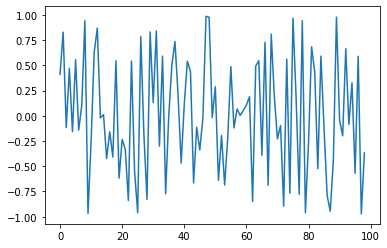

In [30]:
plt.plot(data_param_test[0,:,0])

In [31]:
x0_test = torch.tensor(data_x_test[:,0,:])
x_pred_test = pred_soln(PK_model, x0_test, torch.tensor(data_param_test))

In [32]:
x_pred_test.shape

torch.Size([2, 100, 2])

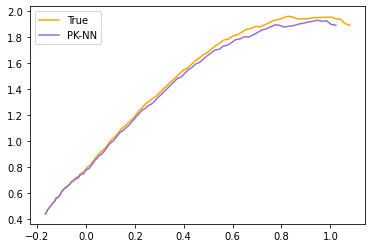

In [33]:
traj_idx = 0
colors = np.linspace(1, 0, traj_len_test)

plt.figure(figsize=(6, 4))
plt.plot(data_x_test[traj_idx, :, 0], data_x_test[traj_idx, :, 1], color='orange', label='True')
plt.plot(x_pred_test[traj_idx, :, 0], x_pred_test[traj_idx, :, 1], color='mediumpurple', label='PK-NN')

plt.legend()

# Try Lightning

In [98]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch


## Define the lightning model

In [99]:
class PKLightningModule(pl.LightningModule):
    def __init__(self, PK_model, loss_function, optimizer_class, lr):
        super().__init__()
        self.PK_model = PK_model
        self.loss_function = loss_function
        self.optimizer_class = optimizer_class
        self.lr = lr
        self.save_hyperparameters()

    def forward(self, x_curr, param_curr):
        return self.PK_model(x_curr, param_curr)

    def training_step(self, batch, batch_idx):
        x_curr, param_curr, x_next = batch
        
        # Forward pass
        psi_x_next_pred = self.PK_model(x_curr, param_curr)
        psi_x_next = self.PK_model.dict(x_next)

        # Calculate loss
        diff = psi_x_next_pred - psi_x_next
        zero = torch.zeros_like(diff)
        loss = self.loss_function(diff, zero)

        # Log the loss to the progress bar
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.parameters(), lr=self.lr)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=20)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'train_loss'
            }
        }
    
    def train_dataloader(self):
        dataset = CustomDataset(data_x_train, data_u_train, data_y_train)
        return DataLoader(dataset, batch_size=64, shuffle=True)


## Train lightning model

In [100]:
from pytorch_lightning import Trainer

n_psi_train = 22
layer_sizes = [100,100,100]
n_psi_train = 22
n_psi = 1 + target_dim + n_psi_train
K_layer_size = [256,256]
dict_nn = PsiNN(inputs_dim=target_dim, 
                layer_sizes=layer_sizes, 
                n_psi_train=n_psi_train, 
                activation_func='tanh') 

model_K = Model_K_u_Layer_One(inputs_dim=param_dim, layer_sizes=K_layer_size, n_psi=n_psi, activation="tanh")

PK_model = Koopman_predictor(dict_nn, model_K)


In [101]:

# Compile the model 
loss_function = torch.nn.MSELoss()
optimizer_class = torch.optim.Adam

# Instantiate the Lightning module
model = PKLightningModule(PK_model, loss_function, optimizer_class, lr=1e-4)

# Train the model
trainer = Trainer(max_epochs=100, accelerator='gpu', devices=1)
trainer.fit(model)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name          | Type              | Params | Mode 
------------------------------------------------------------
0 | PK_model      | Koopman_predictor | 242 K  | train
1 | loss_function | MSELoss           | 0      | train
------------------------------------------------------------
242 K     Trainable params
0         Non-trainable params
242 K     Total params
0.971     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 782/782 [00:07<00:00, 106.70it/s, v_num=10, train_loss=3.42e-7] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 782/782 [00:07<00:00, 106.19it/s, v_num=10, train_loss=3.42e-7]


In [102]:
x_pred_test_pl = pred_soln(PK_model, x0_test, torch.tensor(data_param_test))

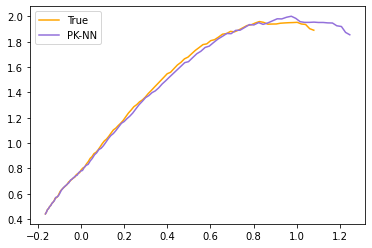

In [103]:
traj_idx = 0
colors = np.linspace(1, 0, traj_len_test)

plt.figure(figsize=(6, 4))
plt.plot(data_x_test[traj_idx, :, 0], data_x_test[traj_idx, :, 1], color='orange', label='True')
plt.plot(x_pred_test_pl[traj_idx, :, 0], x_pred_test_pl[traj_idx, :, 1], color='mediumpurple', label='PK-NN')

plt.legend()